In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from ersilia import ErsiliaModel

from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog("rsApp")


In [2]:
def load_data(path):

    """simple fuction to load in data"""

    data = pd.read_csv(path)
    return data
    
smiles_data = load_data("/home/sonia/ersilia-model-validation/data/reference_library.csv")
smiles_data.head()

,smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...


In [3]:
def smiles_list(data, col):

    """simple function to create a list from the smiles dataframe"""

    lst = data[col].astype(str).tolist()
    return lst

column = 'smiles'
sl = smiles_list(smiles_data, column)
sl[1:21] # preview 20 elements from the list 

['CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1',
 'O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl',
 'O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C23)CC1',
 'CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC=C(C)C=C1',
 'CN1C(=O)C2=C(N=C(N3CCC[C@@H](N)C3)N2CC2=CC(F)=CC=C2Cl)C2=CC=C(C(=O)O)C=C12',
 'CNC(=O)C1=CC=CC2=C1N=C(C1=CC=CC=C1O)N2CC1=CC=CC=C1',
 'C[C@]12CC[C@H](S)C[C@H]1CCC1C3=CC[C@H](C4=CC(=O)OC4)[C@@]3(C)CCC21',
 'CC1=C(C(=O)OCC2=CC=CC=C2)C(C2=CC=C(C3=CC=CC=C3C)C=C2)NC(=S)N1CCCCCC1=NN=NN1',
 'CC(C)CC1=CC(C(=O)NCC2=CC=CN=C2)=NO1',
 'COC(=O)CC1NN=C2N(CCN2C2=CC=C(Cl)C=C2)C1=O',
 'CCN1C2=NC=C(COC3=CC=CC(C(=O)O)=C3)C=C2C(=O)N(C)C2=CC=C(Cl)N=C12',
 'CC1=C(NC(=S)N/N=C\\C2=CC=CC=C2O)C(=O)N(C2=CC=CC=C2)N1C',
 'C[C@@H](O)C1=NC(C2=NC(C3=NC(CO)=CS3)=CS2)=CS1',
 'CCCCCCCCCCCC(=O)CCCC',
 'C=CC1=C(N)N=CN=C1N1CCC(C2=NC(C3=CC=C(C(F)(F)F)C(F)=C3)=CN2CCN2CCCC2)CC1',
 'O=C1/C(=N/C2=CC=C(O)C=C2)C(Cl)=C(O)C2=CC=CC=C12',
 'O=C(O)CC[C@H](NC(=O)C1=CC=CC(C2=CC=CC=C2)=N1)C(=O)N1CCN(C(=O)OCCCC(F)(F)F)CC1',
 'CC(=O)N

### *SMILES*
Chemical compounds can be presented in various forms *i.e molecular formula*, **canonical smiles** are a simple representation of molecules in a text string format

### Molecular Validation
Molecular validation ensures molecules are reasonable for the task at hand, in this case machine learning. It removes compounds with bad elements and substructures. This is done by checking if SMILES can be converted into molecules or not

In [4]:
# convert smiles_list to tuple
smiles_tuple = tuple(sl)

valid_molecules = []
invalid_molecules = []

for i in smiles_tuple:

    # convert SMILES to molecules
    mols = Chem.MolFromSmiles(i, sanitize = False) 
    mols.UpdatePropertyCache(strict=False)
    
    # sanitize molecules for validity
    Chem.SanitizeMol(mols) 
    
    if Chem.SanitizeMol(mols) == 0:
        valid_molecules.append(mols) # append valid molecules to the list valid molecules
    else:
        invalid_molecules.append(mols) # append invalid molecues to the list invalid molecules

# count valid and invalid SMILES
print(f"Number of molecules sanitized successfully: {len(valid_molecules)}")
print(f"Number of invalid SMILES: {len(invalid_molecules)}")

Number of molecules sanitized successfully: 1000
Number of invalid SMILES: 0


### Molecular Standardization
The main reason for standardization is to represent all molecules from different sources in a (single) standard way, for use in machine learning. The standardization looks at a number of different operations like neutralizing molecules, removing salts, modifying molecules and many others

In [23]:
def standardize(smiles_tuple):
    standardized_smiles_list = []

    for smile in smiles_tuple:
        try:
            # Convert SMILES to molecules
            mols = Chem.MolFromSmiles(smile, sanitize=False)
            mols.UpdatePropertyCache(strict=False)

            # Clean up the molecules
            clean_mols = rdMolStandardize.Cleanup(mols)

            # Get parent molecules
            parent_clean_mols = rdMolStandardize.FragmentParent(clean_mols)

            # Neutralize molecules
            uncharger = rdMolStandardize.Uncharger()
            uncharged_parent_clean_mols = uncharger.uncharge(parent_clean_mols)

            # Eliminate pH balance
            te = rdMolStandardize.TautomerEnumerator()
            taut_uncharged_parent_clean_mols = te.Canonicalize(uncharged_parent_clean_mols)

            # Convert standardized molecules back to SMILES
            standardized_smiles = Chem.MolToSmiles(taut_uncharged_parent_clean_mols)

            # Append the standardized SMILES to list
            standardized_smiles_list.append(standardized_smiles)

            """
            when you run the above function without the error exception below
            you will come across the error KekulizeException: Can't kekulize mol.
            this error occurs when a SMILE is missing either nitrogen or hydrogen atoms
            in its structure,
            you can manually find the SMILE giving out the error and
            figure out where to add the atoms and the error would be erased.
            
            In the case you have limited knowledge on how to modify your SMILE
            you can skip such SMILES and remain with the ones that can be kekulized
            """
            
        except Chem.KekulizeException as e:
            # skip molecules that can't be kekulized
            print(f"Skipping molecule due to KekulizeException: {str(e)}")
            continue

    return standardized_smiles_list

In [24]:
processed_smiles_list = standardize(smiles_tuple)

Skipping molecule due to KekulizeException: Can't kekulize mol.  Unkekulized atoms: 4 8
Skipping molecule due to KekulizeException: Can't kekulize mol.  Unkekulized atoms: 2
Skipping molecule due to KekulizeException: Can't kekulize mol.  Unkekulized atoms: 3 4 5 23
Skipping molecule due to KekulizeException: Can't kekulize mol.  Unkekulized atoms: 16 17 18
Skipping molecule due to KekulizeException: Can't kekulize mol.  Unkekulized atoms: 4 9


In [7]:
# preview first 20 standardised molecules
processed_smiles_list[1:21]

['Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1',
 'O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl',
 'O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1',
 'CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1',
 'Cn1c(=O)c2c(nc(N3CCC[C@@H](N)C3)n2Cc2cc(F)ccc2Cl)c2ccc(C(=O)O)cc21',
 'CNC(=O)c1cccc2c1nc(-c1ccccc1O)n2Cc1ccccc1',
 'C[C@]12CCC3C(CC[C@@H]4C[C@@H](S)CC[C@]34C)C1=CC[C@@H]2C1=CC(=O)OC1',
 'CC1=C(C(=O)OCc2ccccc2)C(c2ccc(-c3ccccc3C)cc2)NC(=S)N1CCCCCc1nn[nH]n1',
 'CC(C)Cc1cc(C(=O)NCc2cccnc2)no1',
 'COC(=O)CC1NN=C2N(CCN2c2ccc(Cl)cc2)C1=O',
 'CCN1c2ncc(COc3cccc(C(=O)O)c3)cc2C(=O)N(C)c2ccc(Cl)nc21',
 'Cc1c(NC(=S)NN=Cc2ccccc2O)c(=O)n(-c2ccccc2)n1C',
 'C[C@@H](O)c1nc(-c2nc(-c3nc(CO)cs3)cs2)cs1',
 'CCCCCCCCCCCC(=O)CCCC',
 'C=Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(C(F)(F)F)c(F)c3)cn2CCN2CCCC2)CC1',
 'O=C1C=CC(=Nc2c(Cl)c(O)c3ccccc3c2O)C=C1',
 'O=C(O)CCC(NC(=O)c1cccc(-c2ccccc2)n1)C(=O)N1CCN(C(=O)OCCCC(F)(F)F)CC1',
 'CC(=O)Nc1c2c(nn1-c1ccccc1)C[S+]([O-])C2',
 'O=C(O)CSC(C(=O)Nc1ccc(Cl)cc1)c1ccccc1',
 'O=[N+]([O-])NC1=NCCN1CCC

In [11]:
# length of standardized SMILES
print(f"Number of SMILES after standardization:{len(processed_smiles_list)}")

Number of SMILES after standardization:995


### Chemistry Machine Learning

In [9]:
# instantiate model
model = ErsiliaModel("eos2ta5")

# serve model
model.serve()

# make predictions
# have the predictions in a pandas daframe
output = model.run(processed_smiles_list, output="pandas")

# store predictions in a csv file
output.to_csv("/home/sonia/ersilia-model-validation/data/output-predictions.csv", index=False)

Requested model eos2ta5 is not available locally. Do you want to fetch it? [Y/n]


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


[]


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


🚀 Serving model eos2ta5: cardiotoxnet-herg

   URL: http://127.0.0.1:59175
   PID: 134997
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


⛔ Model eos2ta5 closed


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


In [10]:
predictions_data = pd.read_csv("/home/sonia/ersilia-model-validation/data/output-predictions.csv")
predictions_data.head()

,key,input,probability
0,SUTWUYBMBWPLMW-MDWZMJQESA-N,CCCCNC(=S)N/N=C/c1sccc1C,0.914338
1,RIYHJWOTNJXDLV-UHFFFAOYSA-N,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,0.777395
2,OGNBARHGQVMGGX-UHFFFAOYSA-N,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,0.042147
3,WQEXDIRUOYNDCM-UHFFFAOYSA-N,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,0.413345
4,YEGVLLQDOGYWDQ-OAHLLOKOSA-N,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,0.826203


### Plot Predictions

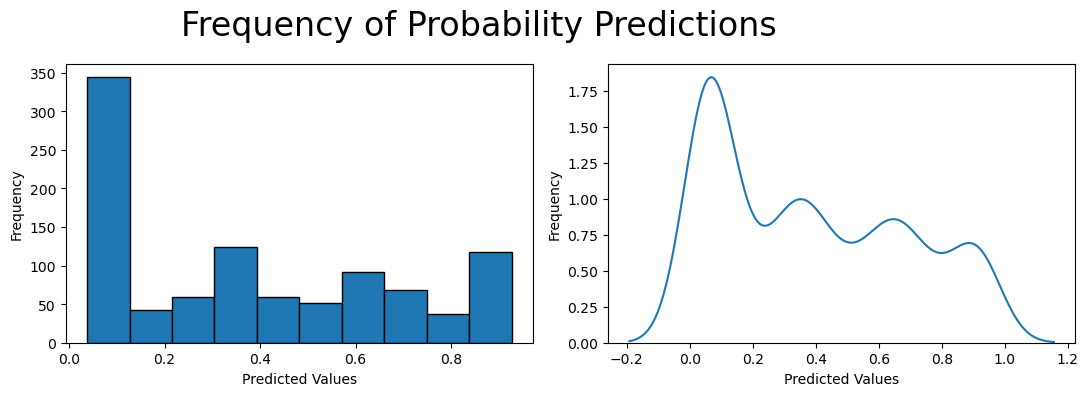

In [46]:
fig, (ax1, ax2) = plt.subplots(figsize = (11, 4), ncols=2)

ax1.hist(predictions_data['probability'], edgecolor = 'black')
ax2 = sns.kdeplot(predictions_data['probability'])

fig.suptitle("Frequency of Probability Predictions", fontsize=24, x=0.44)
ax1.set_xlabel('Predicted Values')
ax2.set_xlabel('Predicted Values')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
plt.tight_layout()
plt.show()



*As we follow through the scale, you notice high frequency when probability is low. As we move along to a probability of 1, the scale seems to fluncuate but its not as high as when the molecules probability of toxicity are in the range of 0.0 - 0.1,the model is meant to predict probability of toxicity in chemical compounds, most of these predictions have low probability of toxicity (i.e <=0.1)*